In [2]:
import pandas as pd
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statistics import mode, mean
import copy

import warnings
warnings.filterwarnings("ignore")

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from sklearn import preprocessing
from math import sqrt
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd 
df=pd.read_csv("/content/drive/MyDrive/tomato.csv", encoding="utf-16", delimiter = "\t")




In [5]:
df.columns

Index(['时间', '日期', '室内温度（℃）', '室内湿度（%）', '室内光照（umol/m2/s）', '室内CO2（ppm）',
       '土壤温度（℃）', '土壤湿度（%）'],
      dtype='object')

In [6]:
df.columns = ['Time','Date', 'Indoor_Temp(℃)', 'Indoor_humidity(%)','Indoor_lighting(umol/m2/s)','Indoor_C02(ppm)','soil_temp(℃)','soil_moisture(%)']

**Data Cleaning**

Time - checking frequency of recordings.

In [8]:
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d.%m.%Y %H:%M:%S')  #pd.to_datetime converts datetime into pandas object
df = df.drop(['Date', 'Time'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319130 entries, 0 to 319129
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Indoor_Temp(℃)              319130 non-null  float64       
 1   Indoor_humidity(%)          319130 non-null  int64         
 2   Indoor_lighting(umol/m2/s)  319130 non-null  int64         
 3   Indoor_C02(ppm)             319130 non-null  int64         
 4   soil_temp(℃)                319130 non-null  float64       
 5   soil_moisture(%)            319130 non-null  int64         
 6   Datetime                    319130 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 17.0 MB


In [9]:
df['freq']=df['Datetime'].diff()
df['freq']=df['freq']/ np.timedelta64(1, 'm')
df['freq']

0         NaN
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
319125    1.0
319126    1.0
319127    1.0
319128    1.0
319129    1.0
Name: freq, Length: 319130, dtype: float64

In [11]:
#df['freq'] - contains difference of each row with its previous row in the float format


from datetime import datetime, timedelta
missing_values=[]
out=df[df['freq']>10].index.to_list()          #finding index number of rows with time difference over 10

for i in range(len(out)):
  variation=math.ceil(df['freq'][out[i]])      #rounding off time difference using funtion math.ceil

  match=[df['Datetime'][out[i]-1] + timedelta(minutes=j) for j in range(variation)]          #finding row in the original dataframe with the index number and then accessing the previous row
  missing_values.append(match)                                                               # addding the time difference to reduce the gap

missing_timestamplist_merged = [item for sublist in missing_values for item in sublist]       #preparing list comprehension
og_timestamp_list = df['Datetime'].to_list()

final_timestamp_list = og_timestamp_list + missing_timestamplist_merged
final_timestamp_list.sort()
     

In [12]:
df1=pd.DataFrame()

df1['Datetime']=final_timestamp_list

df1.shape

(377656, 1)

In [13]:
df2=pd.merge(df,df1,how='left',on='Datetime')
df2=df2.drop('freq',axis=1)
df2.shape
df2.head()

,Indoor_Temp(℃),Indoor_humidity(%),Indoor_lighting(umol/m2/s),Indoor_C02(ppm),soil_temp(℃),soil_moisture(%),Datetime
0,33.0,33,2500,445,26.3,18,2017-05-14 12:55:15
1,33.1,35,2500,448,26.3,18,2017-05-14 12:56:15
2,33.0,33,2500,443,26.3,18,2017-05-14 12:57:15
3,33.0,33,2500,443,26.3,18,2017-05-14 12:58:15
4,32.8,33,2500,448,26.3,18,2017-05-14 12:59:15


**Curve fitting**

In [14]:
min_date=df2['Datetime'][0]
df['hourdiff']=(df['Datetime']-pd.Timestamp(min_date)).astype('timedelta64[h]')
df['hourdiff']

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
           ...  
319125    6410.0
319126    6410.0
319127    6410.0
319128    6410.0
319129    6410.0
Name: hourdiff, Length: 319130, dtype: float64

In [15]:
df2['hourdiff']=(df2['Datetime']-pd.Timestamp(min_date)).astype('timedelta64[h]')
df2['hourdiff']

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
           ...  
322091    6410.0
322092    6410.0
322093    6410.0
322094    6410.0
322095    6410.0
Name: hourdiff, Length: 322096, dtype: float64

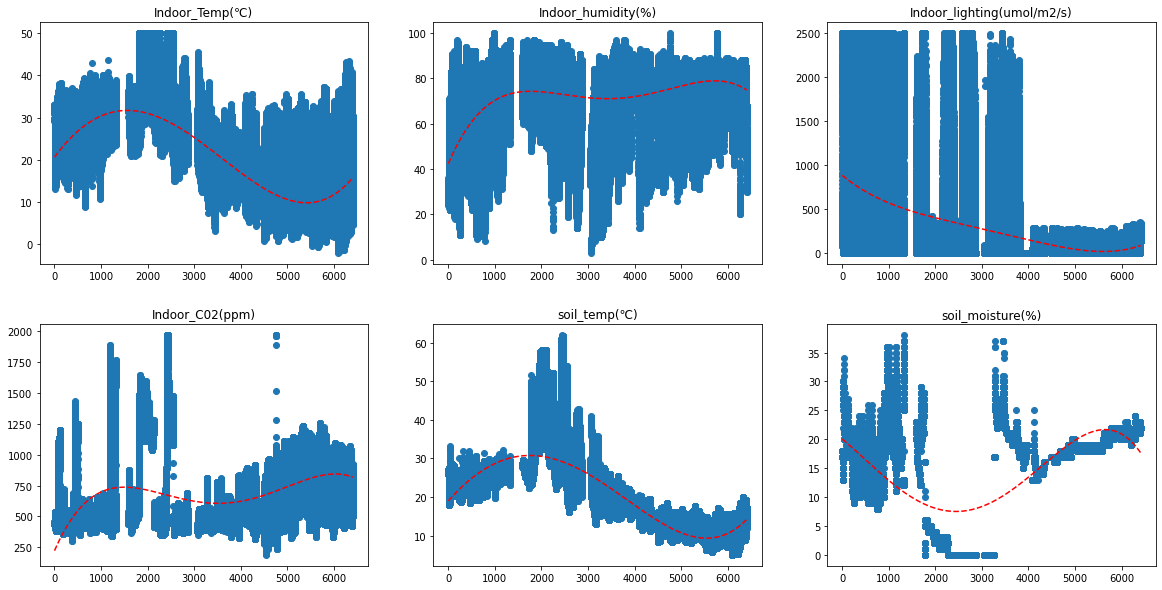

In [16]:
from scipy.optimize import curve_fit

def objective1(x, a, b, c, d, e):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e

col_list = df.set_index('Datetime').columns.to_list()[:6]   #curvefitting doesn't take datetime. 


plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.25)

for n, col in enumerate(col_list):

  # add a new subplot iteratively
  ax = plt.subplot(2, 3, n + 1)

  x, y = df["hourdiff"], df[col]
  popt, _ = curve_fit(objective1, x, y)
  # summarize the parameter values
  a, b, c, d, e  = popt

  # plot input vs output
  ax.scatter(x, y)
  
  # define a sequence of inputs between the smallest and largest known inputs
  x_line = np.arange(min(x), max(x), 1)
  # calculate the output for the range
  y_line = objective1(x_line, a, b, c, d, e)
  # create a line plot for the mapping function
  ax.plot(x_line, y_line, '--', color='red')

  # chart formatting
  ax.set_title(col)  
plt.show()

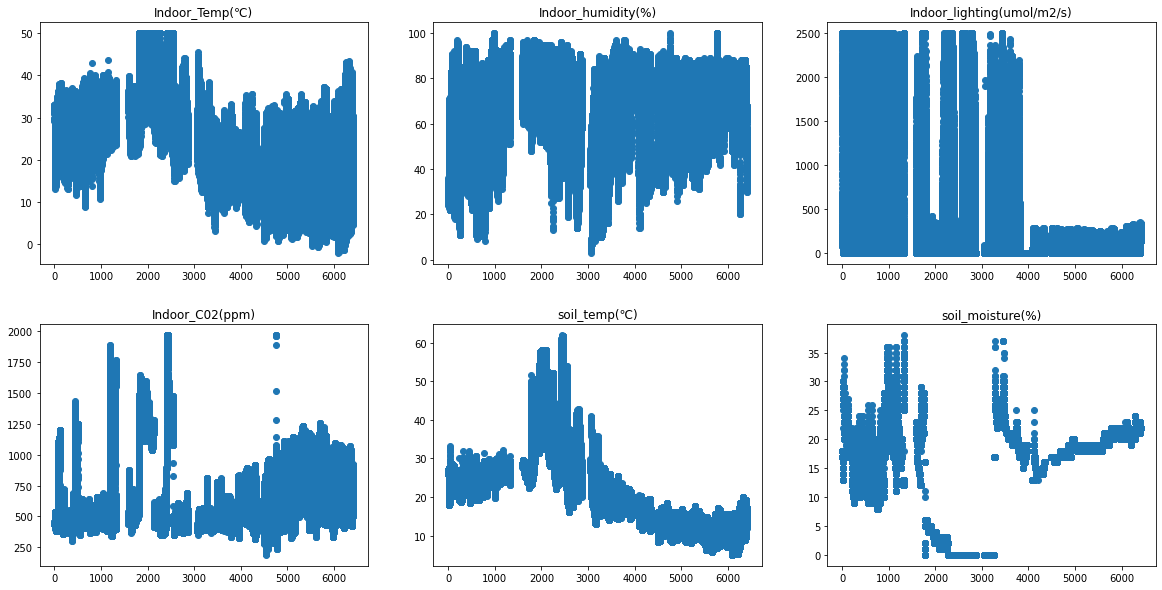

In [17]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.25)

for n, col in enumerate(col_list):

  # add a new subplot iteratively
  ax = plt.subplot(2, 3, n + 1)

  x, y = df["hourdiff"], df[col]
  popt, _ = curve_fit(objective1, x, y)
  # summarize the parameter values
  a, b, c, d, e  = popt

  for i in range(df2.shape[0]):
    if pd.isna(df2[col][i]) == True:
      df2[col][i] = objective1(df2['hourdiff'][i], a, b, c, d, e)

  ax.scatter(df2['hourdiff'], df2[col]);
  ax.set_title(col)

plt.show()

**Correlation between variables:**

**Summary:**

**Soil**: 

Soil temperature is higher than indoor temperature only during some parts of August (hottest month of Algiers) and September.

Soil retained a good amount of moisture from mid-November till Febraury.
Between August and September - the moisture content remains very low.
June and July - moisture content seems fluctuating.


**Humidity** is always higher than indoor temperature.


**Indoor Temperature:** 

**Artifical lighting** is an absolute necessary for the greenhouse in Algeria.


**Indoor CO2:**

The proportion of Indoor CO2 is higher when compared with other variables except for Indoor lighting.

Even in Indoor lighting, the CO2 ratio is higher from November till Febraury.

---



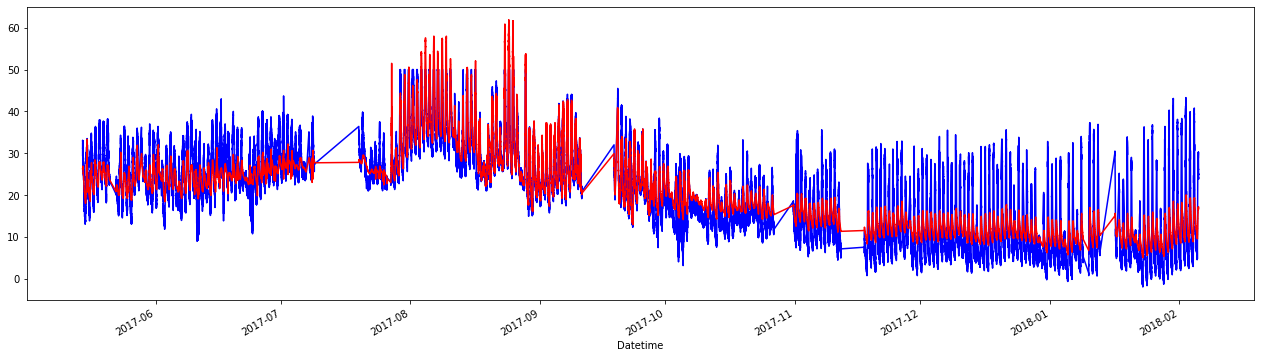

In [18]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_Temp(℃)'].plot(color='blue')
df2.set_index('Datetime')['soil_temp(℃)'].plot(color='red')

plt.show()

Soil temperature is higher than indoor temperature only during some parts of August and September.

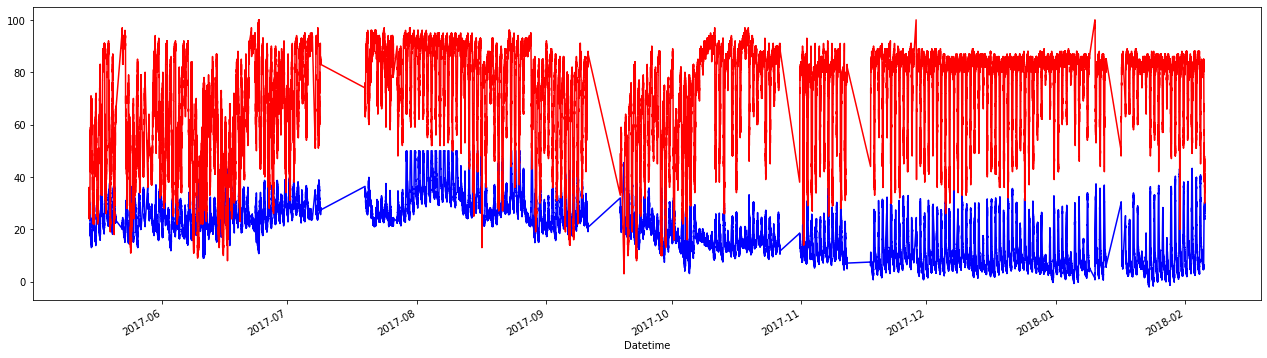

In [19]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_Temp(℃)'].plot(color='blue')
df2.set_index('Datetime')['Indoor_humidity(%)'].plot(color='red')

plt.show()

Humidity and Temperature are directly correlated.

Humidity is always higher than indoor temperature.

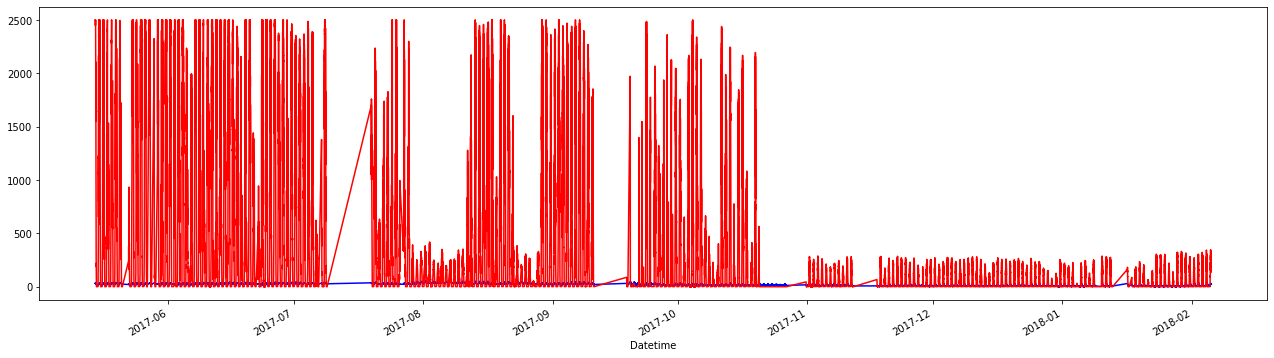

In [ ]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_Temp(℃)'].plot(color='blue')
df2.set_index('Datetime')['Indoor_lighting(umol/m2/s)'].plot(color='red')

plt.show()

Artifical lighting is an absolute necessary for the greenhouse in Algeria.



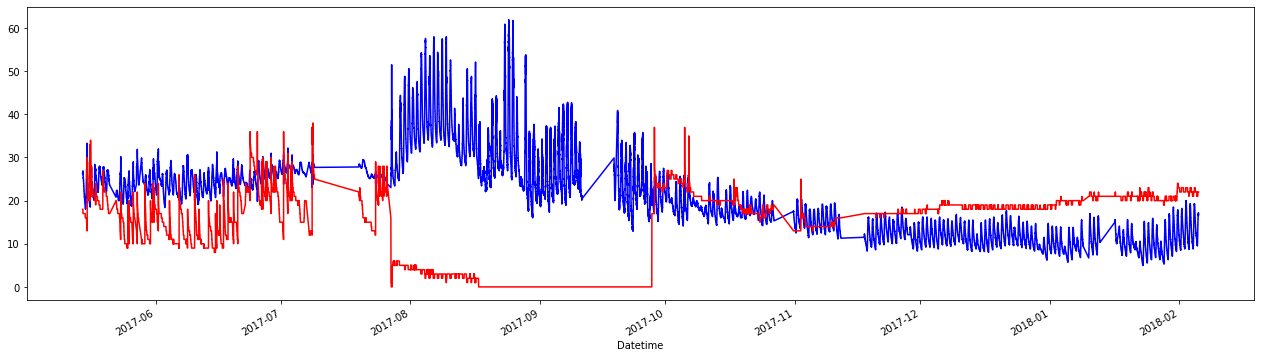

In [ ]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['soil_temp(℃)'].plot(color='blue')
df2.set_index('Datetime')['soil_moisture(%)'].plot(color='red')

plt.show()

The soil retained good amount of moisture from mid-November till Febraury. 

Between August and September - the moisture content remains very low.

June and July - moisture content seems fluctuating.

CO2 proportion

The proportion of Indoor CO2 is higher when compared with other variables except for Indoor lighting.

Even in Indoor lighting, the CO2 ratio is higher from November till Febraury.

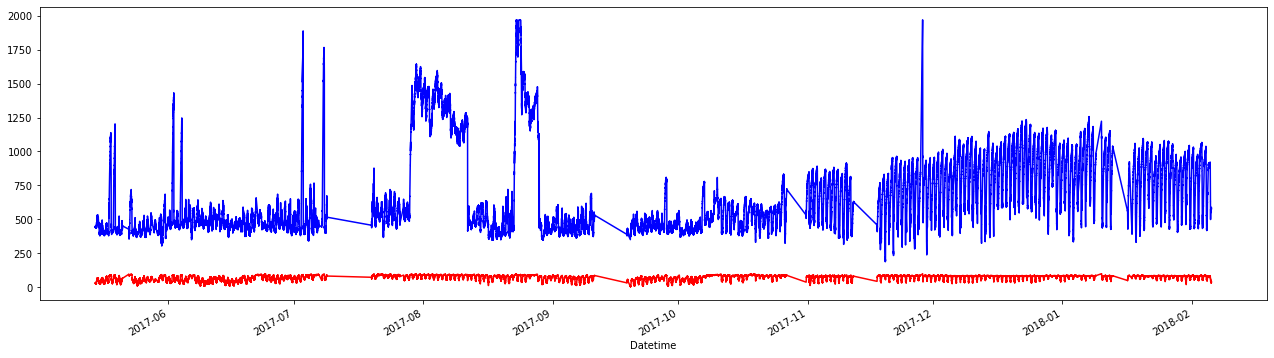

In [ ]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_C02(ppm)'].plot(color='blue')
df2.set_index('Datetime')['Indoor_humidity(%)'].plot(color='red')

plt.show()

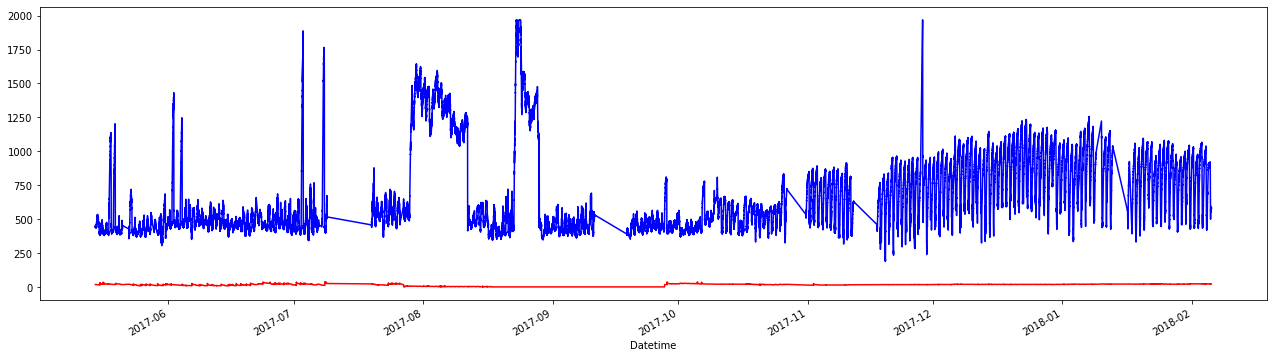

In [ ]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_C02(ppm)'].plot(color='blue')
df2.set_index('Datetime')['soil_moisture(%)'].plot(color='red')

plt.show()

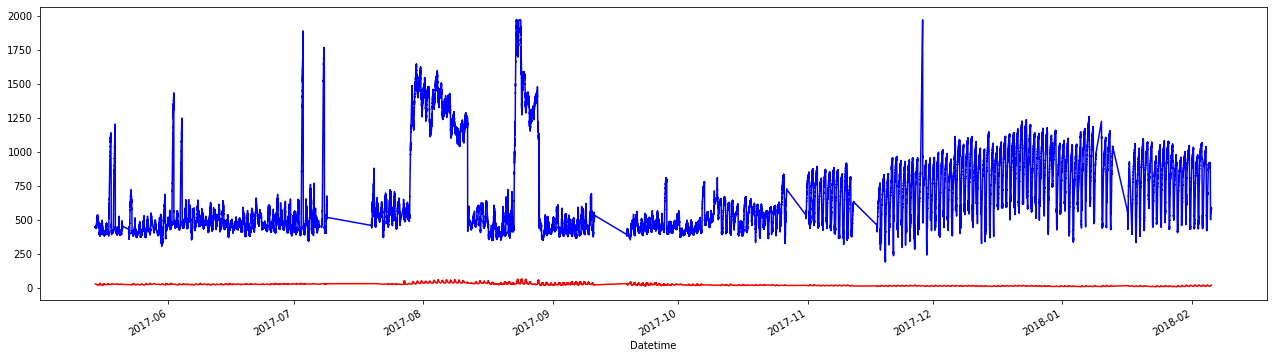

In [ ]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_C02(ppm)'].plot(color='blue')
df2.set_index('Datetime')['soil_temp(℃)'].plot(color='red')

plt.show()

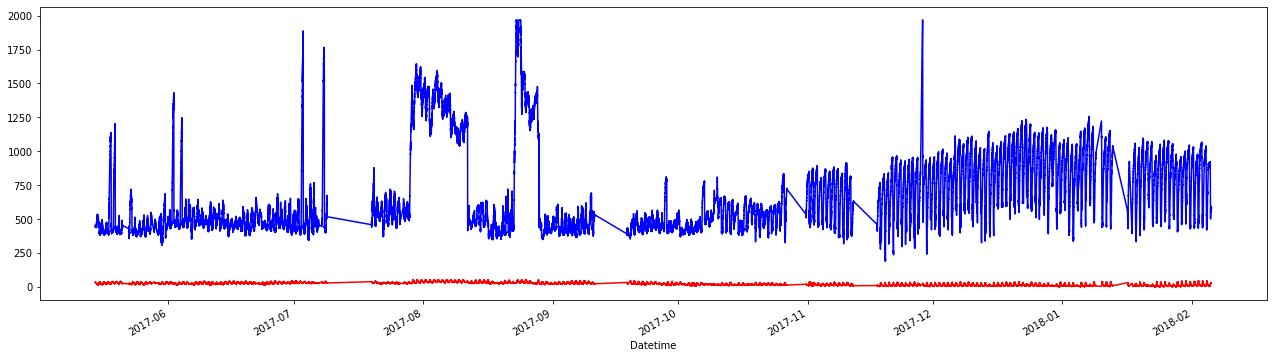

In [ ]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_C02(ppm)'].plot(color='blue')
df2.set_index('Datetime')['Indoor_Temp(℃)'].plot(color='red')

plt.show()

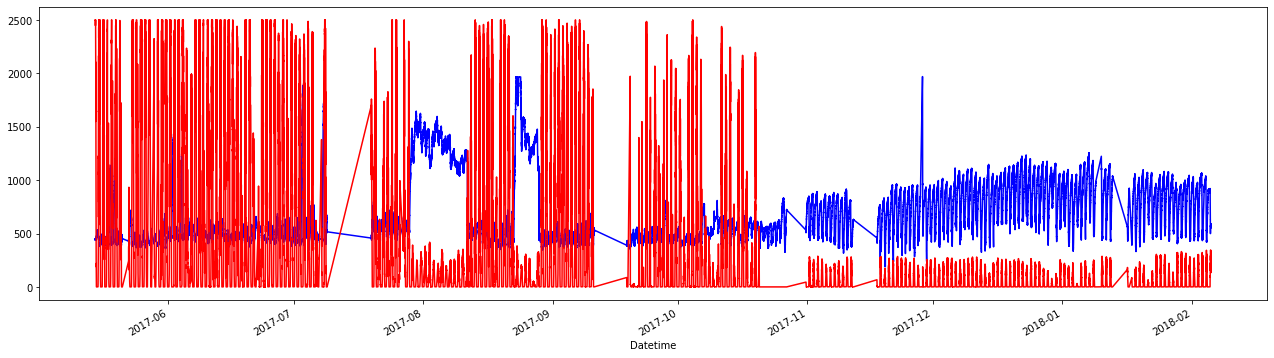

In [ ]:
plt.figure(figsize = (22,6))
df2.set_index('Datetime')['Indoor_C02(ppm)'].plot(color='blue')
df2.set_index('Datetime')['Indoor_lighting(umol/m2/s)'].plot(color='red')

plt.show()

Day and Night Variation:

In [20]:
df2['Hour']=df2["Datetime"].dt.hour
df2['Hour'].isnull().sum()

0

In [21]:
df2['period']=df2['Hour']%24+4//4

In [22]:
df2['Day']=""
df2['Night']=""

for i in range(len(df2["Hour"])):
  if df2['period'][i] in range(6,18):
    df2['Day'][i]='Day'
    
  else:
    df2['Night'][i]='Night'

  


In [23]:
df2['month']=df2["Datetime"].dt.month

In [28]:
df2['new']=df2['month'].astype(str)+ "" + df2['Day']

df2['new_night']=df2['month'].astype(str)+" "+df2['Night']

**Day-Night variations based on months:**

**Summary**

There is not much variation in the variables during the day and night for all the months. 



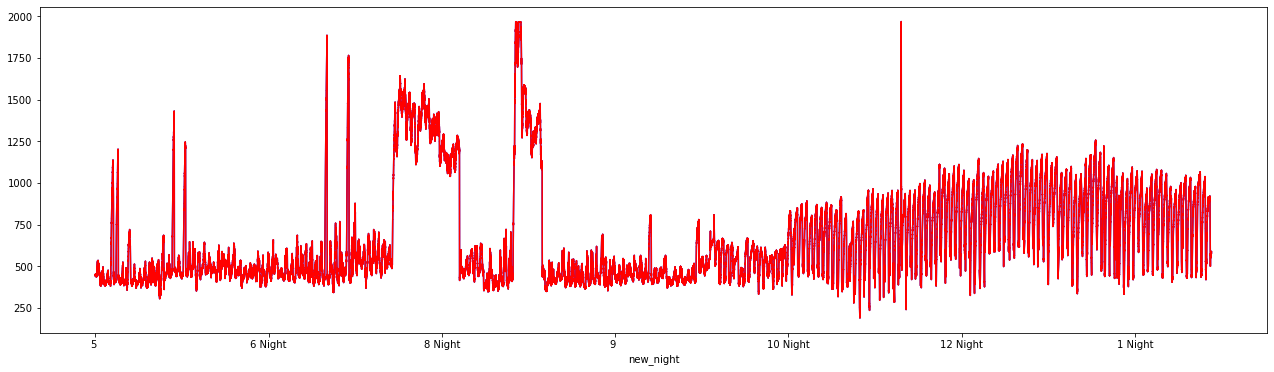

In [49]:
plt.figure(figsize = (22,6))
df2.set_index('new')['Indoor_C02(ppm)'].plot(color='blue')
df2.set_index('new_night')['Indoor_C02(ppm)'].plot(color='red')
plt.show()

Indoor CO2 proportion remained same during the day and night irrespective of months.

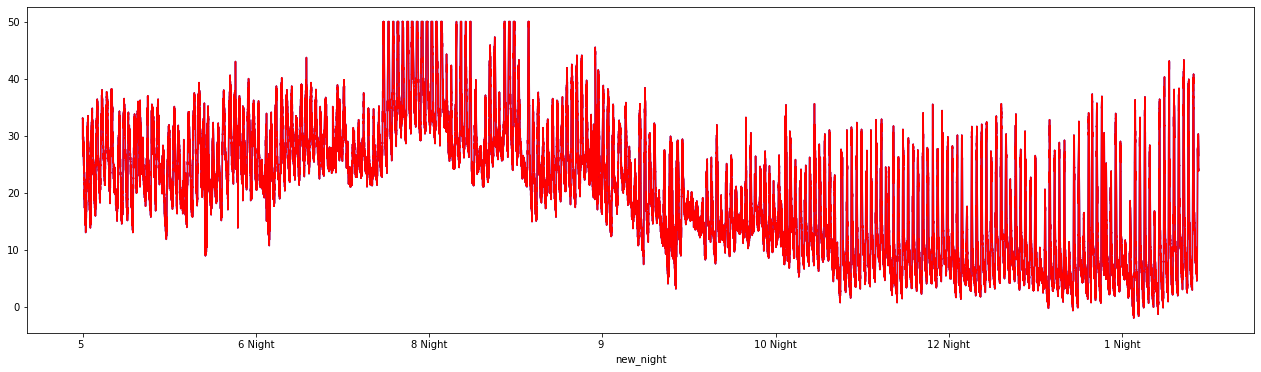

In [48]:
plt.figure(figsize = (22,6))
df2.set_index('new')['Indoor_Temp(℃)'].plot(color='blue')
df2.set_index('new_night')['Indoor_Temp(℃)'].plot(color='red')
plt.show()

Indoor Temperature has remained same during day and night in all the months.

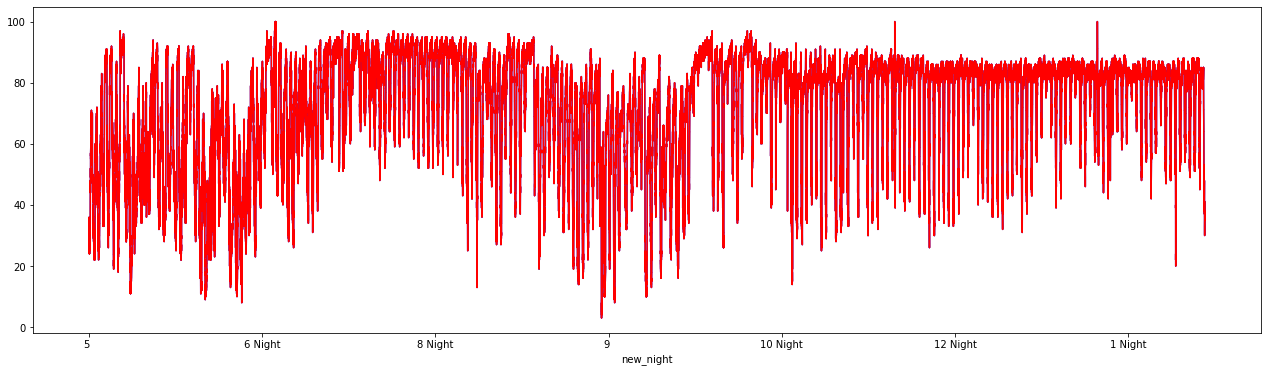

In [47]:
plt.figure(figsize = (22,6))
df2.set_index('new')['Indoor_humidity(%)'].plot(color='blue')
df2.set_index('new_night')['Indoor_humidity(%)'].plot(color='red')
plt.show("Day")

Humidity has remained same during day and night for all the months.

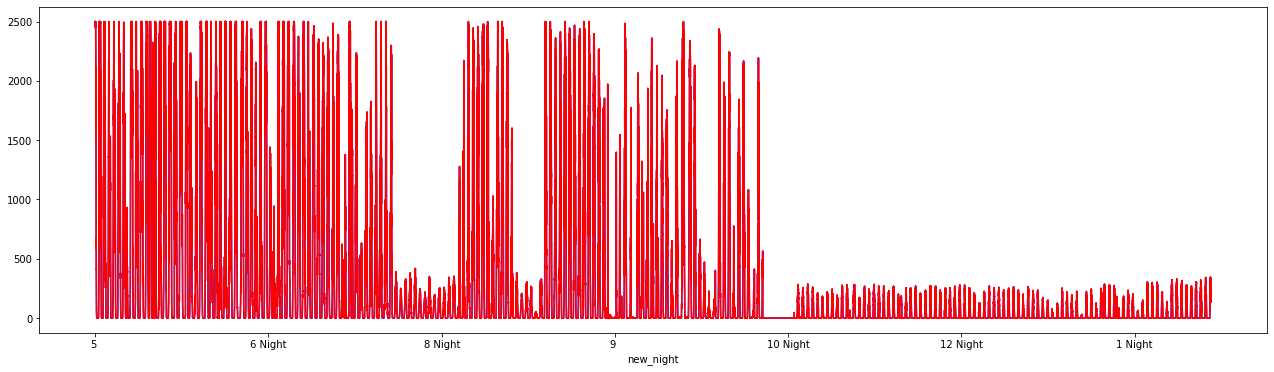

In [46]:
plt.figure(figsize = (22,6))
df2.set_index('new')['Indoor_lighting(umol/m2/s)'].plot(color='blue')
df2.set_index('new_night')['Indoor_lighting(umol/m2/s)'].plot(color='red')
plt.show("Day")

Lighting has also remained same for all the months.

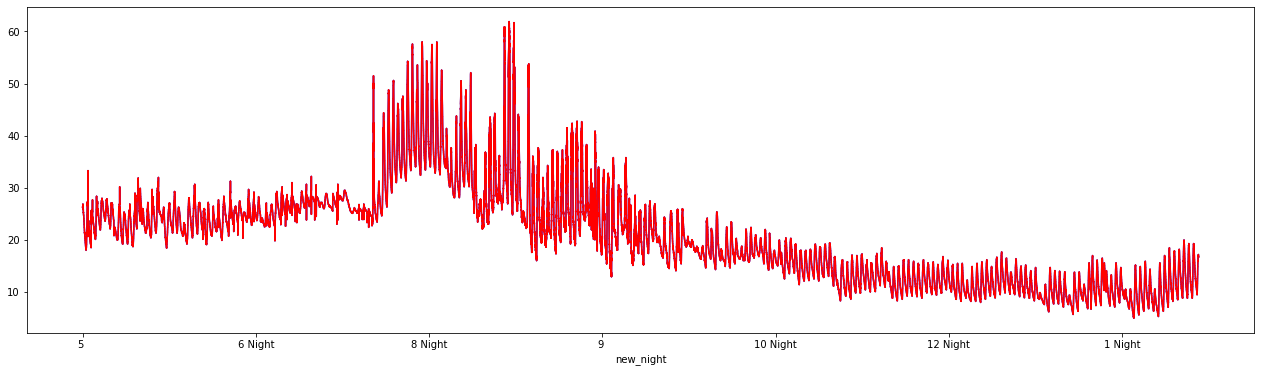

In [45]:
plt.figure(figsize = (22,6))
df2.set_index('new')['soil_temp(℃)'].plot(color='blue')
df2.set_index('new_night')['soil_temp(℃)'].plot(color='red')
plt.show("Day")

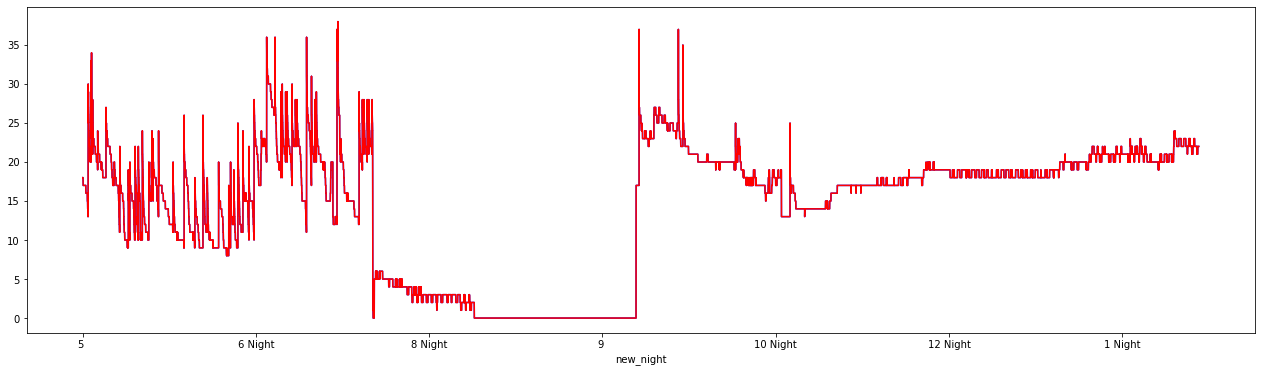

In [44]:
plt.figure(figsize = (22,6))
df2.set_index('new')['soil_moisture(%)'].plot(color='blue')
df2.set_index('new_night')['soil_moisture(%)'].plot(color='red')
plt.show("Day")